In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
from tqdm.auto import tqdm
import evaluate
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
import json
from sklearn.model_selection import train_test_split

from TextDataset import TextDataset
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

from matplotlib import pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

mps


## Config tokenizer and model

#### Call BertModel

In [3]:
# Create a config with the desired settings
config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True, num_labels=2)

# Load the model with the custom config
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# new_tokens = ['[/]', '[//]', '(g)', '##in', '\n']
new_tokens = ['\n']
tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/alan/anaconda3/envs/capstone/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding(30523, 768, padding_idx=0)

#### Call AutoModel

In [4]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2,attentions=True)

# # Add your custom tokens
# new_tokens = ['[/]', '[//]']
# tokenizer.add_tokens(new_tokens)
# model.resize_token_embeddings(len(tokenizer))

## Load Data

In [5]:
def load_data(json_file):
    with open(json_file, 'r') as f:
        data_list = json.load(f)
    lines = [item['line'] for item in data_list]
    labels = [item['label'] for item in data_list]
    return lines, labels

lines, labels = load_data("../data/pitt_cookie_cleaned_first_try.json")

In [6]:
lines_train, lines_test, labels_train, labels_test = train_test_split(
        lines, labels, test_size=0.3, random_state=42
    )

train_dataset = TextDataset(lines_train, labels_train, tokenizer)
test_dataset = TextDataset(lines_test, labels_test, tokenizer)


train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [7]:
lines_test[-1:]

["okay ‡ the mommy is   dryin the dishes . \n the boy is takin a cookie from the cookie jar . \n and he's gonna hand it to his little sister . \n and the bench   is toppling over as the kid is standing on .  \n and the water's dripping out_of the sink . \n  okay ?  "]

## Set Up Model

In [8]:
optimizer = AdamW(model.parameters(), lr=5e-5)

# Learning rate scheduler
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30523, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Train

In [28]:
def model_accuracy(model, dataloader, device):
    """Evaluates the model on the given dataloader and returns accuracy, precision, recall, and F1 score."""
    model.eval()  # Set the model to evaluation mode

    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            logits = outputs.logits

            # Get predictions
            predictions = torch.argmax(logits, dim=-1)
            labels = batch['labels']

            # Update correct predictions and totals
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            # Collect all predictions and labels for other metrics
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions

    return accuracy

In [29]:
progress_bar = tqdm(range(num_training_steps))

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        progress_bar.update(1)
        
    # epoch_accuracy = model_accuracy(model, test_dataloader, device)
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2, Loss: 67.0019
Epoch 2/2, Loss: 57.2449


## Test

In [30]:
# Load the metrics you want to compute
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

model.eval()  # Set the model to evaluation mode
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Move predictions and references to CPU and convert to numpy arrays
    predictions_cpu = predictions.cpu().numpy()
    references_cpu = batch["labels"].cpu().numpy()

    # Add batch to each metric
    accuracy_metric.add_batch(predictions=predictions_cpu, references=references_cpu)
    precision_metric.add_batch(predictions=predictions_cpu, references=references_cpu)
    recall_metric.add_batch(predictions=predictions_cpu, references=references_cpu)
    f1_metric.add_batch(predictions=predictions_cpu, references=references_cpu)

# Compute the metrics
accuracy = accuracy_metric.compute()
precision = precision_metric.compute(average='weighted')
recall = recall_metric.compute(average='weighted')
f1 = f1_metric.compute(average='weighted')

print("Accuracy:", accuracy['accuracy'])
print("Precision:", precision['precision'])
print("Recall:", recall['recall'])
print("F1 Score:", f1['f1'])

Accuracy: 0.7696969696969697
Precision: 0.7776857875024641
Recall: 0.7696969696969697
F1 Score: 0.7695954549906946


## First Try on visualize Attention

In [31]:
from typing import Union

import numpy as np
import seaborn as sns
from ansi.colour import rgb


def color_text(text, rgb_code):
    reset =  '\x1b[0m'
    return rgb.rgb256(*rgb_code) + text + reset

def value2rgb(value):
#     if value < 0:
#         rgb_code = (255/2 + abs(value)/2, abs(value), 255/2 + abs(value)/2)
#     else:
#         rgb_code = (125+value/2, 0, 255/2-value/2)
    if value < 0:
        rgb_code = (255, 255, abs(value))
    else:
        rgb_code = (255, 255-value, 0)
    return rgb_code


def scale(values, input_range, output_range):
    return np.interp(values, input_range, output_range)


def get_legends(value_range, scale_to, step=5):
    min_value, max_value = value_range
    leg_values = np.linspace(min_value, max_value, step)
    scaled_values = scale(leg_values, (min_value, max_value), scale_to)
    
    legends = []
    for leg_value, scaled_value in zip(leg_values, scaled_values):
         legends.append(color_text('{:.2f}'.format(leg_value), value2rgb(scaled_value)))
    return legends


def color_texts(texts, values, use_absolute):
    if use_absolute:
        value_range = (0, 1)
    else:
        value_range = (min(values), max(values))
    scale_to = (-255, 255)
    scaled_values = scale(values, value_range, scale_to)
    result = []
    for text, value in zip(texts, scaled_values):
        rgb = value2rgb(value)
        result.append(color_text(text, rgb))
       
    
    colored = ' '.join(result)
    legends = get_legends(value_range, scale_to)

    colored += ' ({})'.format(' '.join(legends))
        
    if use_absolute:
        colored += ' (min: {:.10f} max: {:.10f})'.format(min(values), max(values))
    
    return colored


def visual_matrix(matrix, labels=None, title=None, **kwargs):

    sns.set()
    plt.figure(figsize=(20,20))
    ax = sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, **kwargs)
    if title:
        ax.set(title = title)
#     ax.xaxis.tick_top()

    return ax


def get_or_default_config(layer_num, batch_num, head_num, token_num, atn_axis, atns):
    if layer_num is None:
        layer_num = -1  # last layer
    
    batch_size = len(atns[0])
    if batch_size == 1:
        batch_num = 0
    else:
        if batch_num is None:
            raise ValueError('You input an attention with batch size != 1. Please input attentions with batch size 1 or specify the batch_num you want to visualize.')
            
    if head_num is None:
        head_num = 'average'

    if token_num is None:
        token_num = 'average'

    if atn_axis is None:
        atn_axis = 0
        
    return layer_num, batch_num, head_num, token_num, atn_axis


def get_multihead_atn_matrix(atns, layer_num=None, batch_num=None):
    
    
#     layer_num, batch_num = get_or_default_layer_and_batch_num(layer_num, batch_num, atns)
    
    layer = atns[layer_num]

    try:
        multihead_atn_matrix = layer[batch_num].detach().numpy()  # pytorch
    except TypeError:
        multihead_atn_matrix = layer[batch_num].cpu().numpy()  # pytorch
    except AttributeError:
        multihead_atn_matrix = layer[batch_num]  # tensorflow

    return multihead_atn_matrix


def get_atn_matrix_from_mh_matrix(multihead_atn_matrix, head_num):
    # atn_matrix: (sequence_length, sequence_length)       
    try:
        atn_matrix = multihead_atn_matrix[head_num]
    except (IndexError, TypeError):
        # average over heads        
        atn_matrix = np.mean(multihead_atn_matrix, axis=0)

    return atn_matrix


def merge_atn_matrix(atn_matrix, mean_over_mat_axis):
    atn_matrix_over_axis: list = np.mean(atn_matrix, axis=mean_over_mat_axis)
    return atn_matrix_over_axis


def matrix2values(matrix, index='average', axis=0):
    
    if index == 'average':
        result_mat = np.mean(matrix, axis=axis)
    elif isinstance(index, int):
        if axis == 0:
            result_mat = matrix[index]
        elif axis == 1:
            result_mat = matrix.T[index]
        else:
            raise ValueError('matrix to values have a wrong axis (0 or 1): ' + str(axis))
    else:
        raise ValueError('matrix to values have a wrong index ("average" or integers): ' + str(index))
    
    return result_mat
        

def get_atn_values(layer_num, batch_num, head_num, token_num, atn_axis, atns):
    layer_num, batch_num, head_num, token_num, atn_axis = get_or_default_config(layer_num, batch_num, head_num, token_num, atn_axis, atns)
    multihead_atn_matrix = get_multihead_atn_matrix(atns, layer_num=layer_num, batch_num=batch_num)
    atn_matrix = get_atn_matrix_from_mh_matrix(multihead_atn_matrix, head_num=head_num)
    atn_values = matrix2values(atn_matrix, index=token_num, axis=atn_axis)
    
    return atn_values


def get_atn_matrix(layer_num, batch_num, head_num, atns):
    layer_num, batch_num, head_num, *_ = get_or_default_config(layer_num, batch_num, head_num, None, None, atns)

    multihead_atn_matrix = get_multihead_atn_matrix(atns, layer_num=layer_num, batch_num=batch_num)
    atn_matrix = get_atn_matrix_from_mh_matrix(multihead_atn_matrix, head_num=head_num)
    return atn_matrix


def visual_atn(labels, atns, layer_num=None, batch_num=None, head_num=None, token_num=None, atn_axis=None,
               use_absolute=False, output=False, **kwargs):
    atn_values = get_atn_values(layer_num, batch_num, head_num, token_num, atn_axis, atns)
    layer_num, batch_num, head_num, token_num, atn_axis = get_or_default_config(layer_num, batch_num, head_num, token_num, atn_axis, atns)

    assert len(labels) == len(atn_values), 'len(labels): {}, len(merged_atn_values): {}'.format(len(labels), len(atn_values))

    colored = color_texts(labels, atn_values, use_absolute)

    try:
        label = labels[token_num]
    except TypeError:
        label = 'ALL_TOKENS'

    print('(layer) {} (batch) {} (head) {} (token_num) {} (token) {} (axis) {}'.format(layer_num, batch_num, head_num, token_num, label, atn_axis))

    if output:
        return colored, atn_values
    else:
        return colored

    
# def visual_atn_matrix(labels, atns, layer_num=None, batch_num=None, head_num=None, token_num=None, output=False) -> 'Axes':
    
#     atn_matrix = get_atn_matrix(layer_num, batch_num, head_num, atns)
    
#     layer_num, batch_num, head_num, token_num, _ = get_or_default_config(layer_num, batch_num, head_num, token_num, None, atns)
    
#     title = '(layer) {} (batch) {} (head) {}'.format(layer_num, batch_num, head_num)
    
#     if output:
#         return visual_matrix(atn_matrix, labels, title=title), atn_matrix
#     else:
#         return visual_matrix(atn_matrix, labels, title=title)
def visual_atn_matrix(labels, atns, layer_num=None, batch_num=None, head_num=None, token_num=None, output=False, num_tokens=None):
    # Get the attention matrix
    atn_matrix = get_atn_matrix(layer_num, batch_num, head_num, atns)
    
    # Slice the attention matrix and labels if num_tokens is specified
    if num_tokens is not None:
        atn_matrix = atn_matrix[:num_tokens, :num_tokens]
        labels = labels[:num_tokens]
    
    # Get or set default configurations
    layer_num, batch_num, head_num, token_num, _ = get_or_default_config(layer_num, batch_num, head_num, token_num, None, atns)
    
    # Set the title for visualization
    title = '(layer) {} (batch) {} (head) {}'.format(layer_num, batch_num, head_num)
    
    # Visualize the attention matrix
    if output:
        return visual_matrix(atn_matrix, labels, title=title), atn_matrix
    else:
        return visual_matrix(atn_matrix, labels, title=title)

In [32]:
tokens = [tokenizer.decode(id_) for id_ in batch["input_ids"][0]]

In [33]:
attentions = outputs.attentions

(layer) 10 (batch) 0 (head) average (token_num) average (token) ALL_TOKENS (axis) 0
[ C L S ] o k a y ‡ t h e m o m m y i s [ / / ] d r y # # i n ( g ) t h e d i s h e s 
 t h e b o y i s t a k # # i n ( g ) a c o o k i e f r o m t h e c o o k i e j a r 
 a n d h e ' s g o n n a h a n d i t t o h i s l i t t l e s i s t e r 
 a n d t h e b e n c h i s t o p # # p l i n g o v e r a s t h e k i d i s s t a n d i n g o n 
 a n d t h e w a t e r ' s d r i p p i n g o u t _ o f t h e s i n k 
 ( ) o k a y ? [ S E P ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ P A D ] [ 

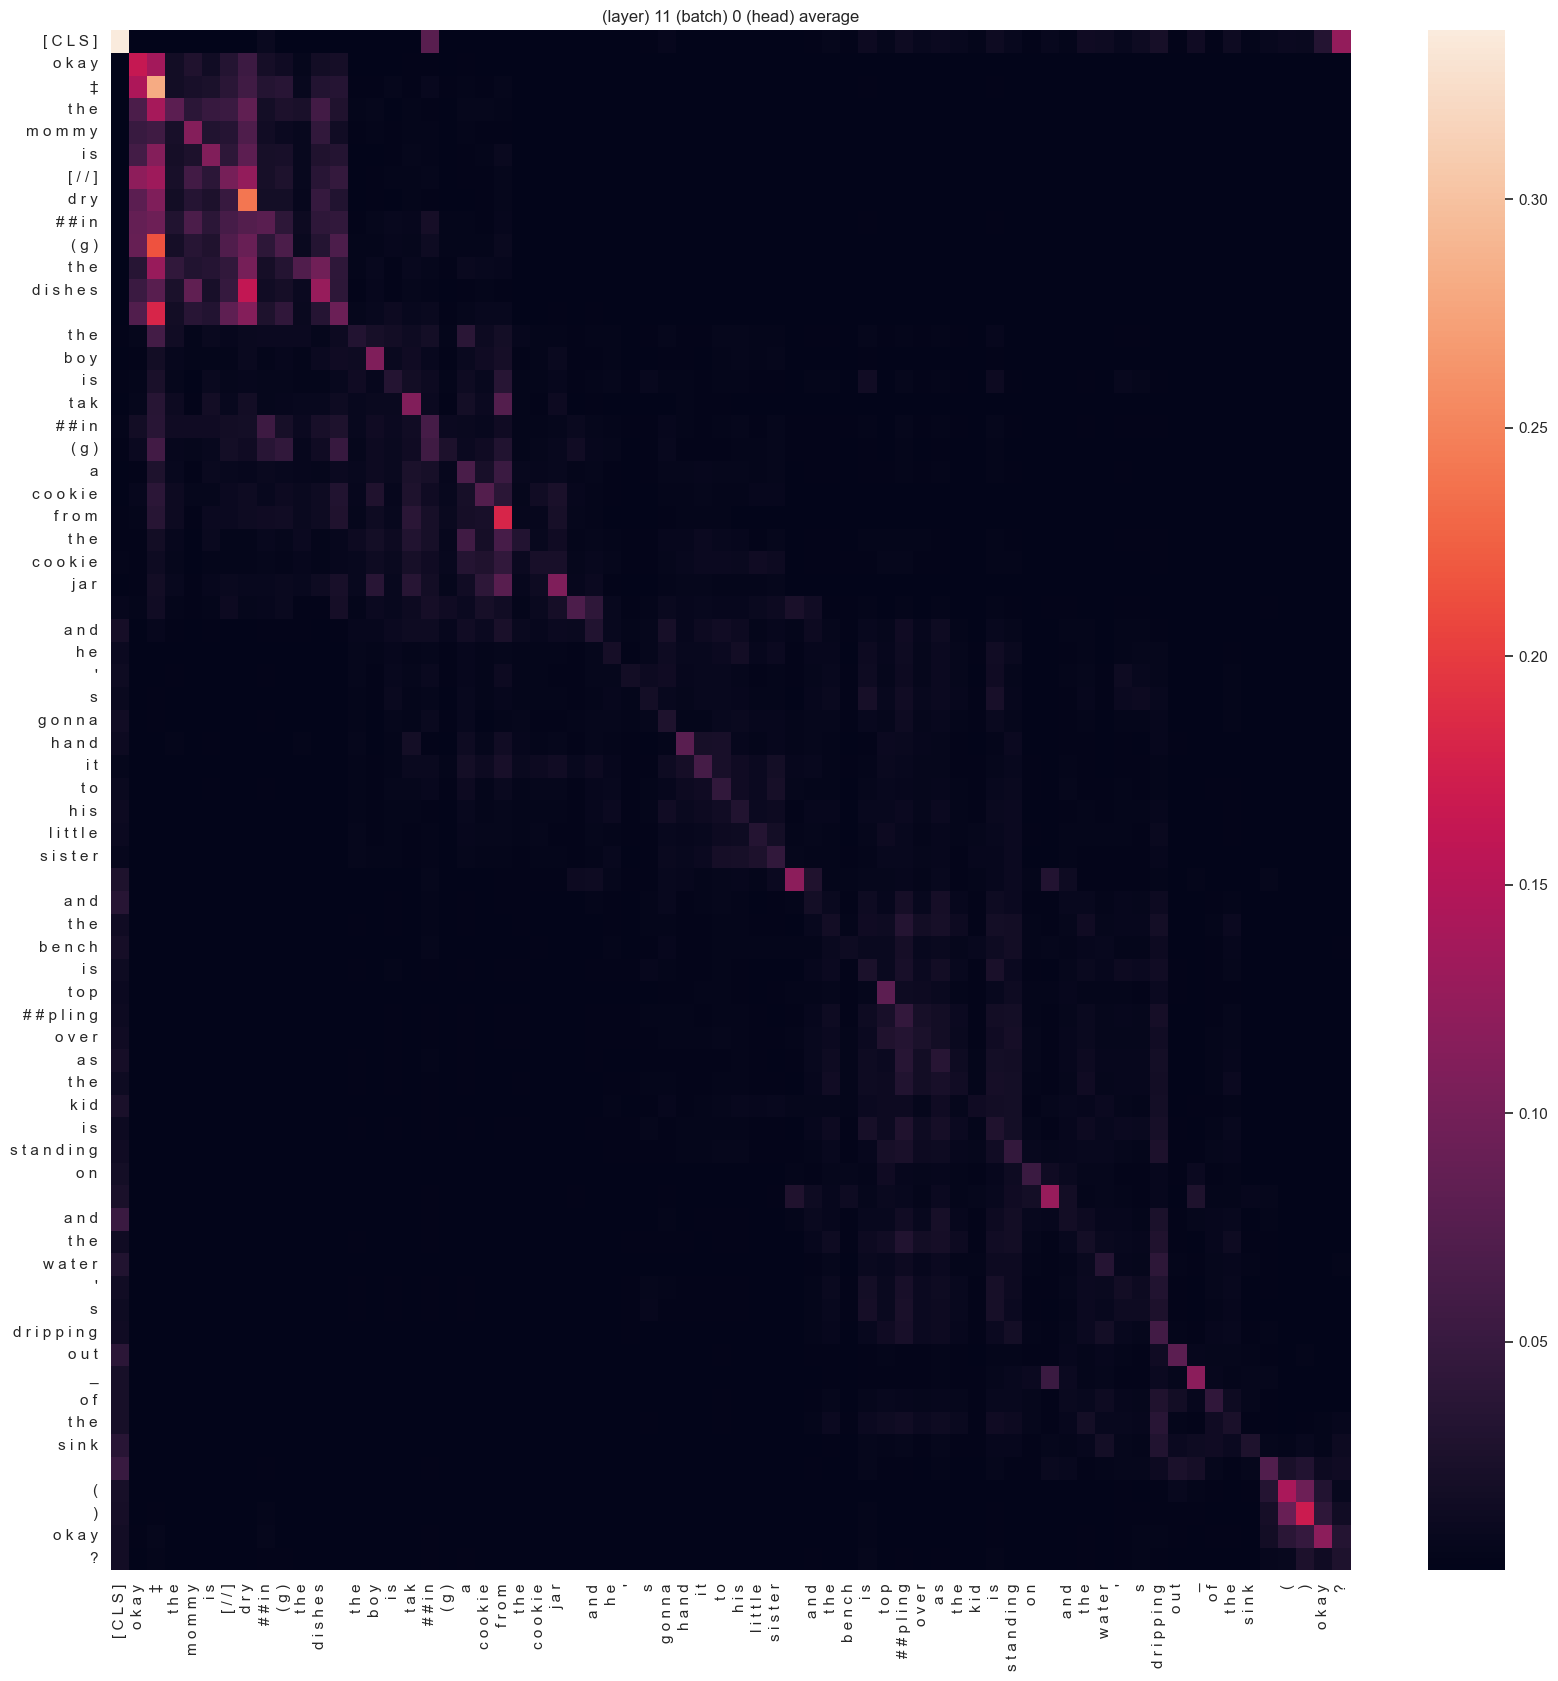

<Figure size 2000x2000 with 0 Axes>

In [38]:
print(visual_atn(tokens, attentions, layer_num=10))
visual_atn_matrix(tokens, attentions, layer_num=11, num_tokens=68)
plt.figure(figsize = (20, 20))
plt.show()

In [16]:
len(attentions[0][0][0][:20])

20

In [17]:
sub_attentions = attentions[0][0, 0, :20, :20]

In [18]:
len(sub_attentions)

20

In [19]:
len(tokens)

512

In [39]:
logits

tensor([[-0.3355,  0.7653]], device='mps:0')